In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from patsy import dmatrices, dmatrix
import statsmodels.discrete.count_model as smdc
import pyarrow as pa

from scipy.stats import ttest_ind
import pyarrow.parquet as pq
import pickle
import re
import os


# setup

In [2]:
def poisson_model(counts_parq, patsy_formula):
    # counts_model_poisson = smdc.GeneralizedPoisson.from_formula(formula = patsy_formula, data = counts_parq)

    # return counts_model_poisson
    return

def zi_poisson_model(counts_parq, patsy_formula):
    # counts_model_zi_poisson = smdc.ZeroInflatedPoisson.from_formula(formula = patsy_formula, data = counts_parq)

    # return counts_model_zi_poisson
    return

def negative_binomial_model(counts_parq, patsy_formula):
    # counts_model_negative_binomial = smdc.NegativeBinomialP.from_formula(formula = patsy_formula, data = counts_parq)

    # return counts_model_negative_binomial
    return

def zi_negative_binomial_model(counts_parq, patsy_formula, zi_param):
    counts_model_zi_negative_binomial = smdc.ZeroInflatedNegativeBinomialP.from_formula(formula = patsy_formula, data = counts_parq, exog_infl = pd.get_dummies(pd.Categorical(counts_parq.__getitem__(zi_param))))

    return counts_model_zi_negative_binomial

def get_stats(fit_model):
    print('getting stats')
    # available stats come from here https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.CountResults.html

    aic = fit_model.aic
    bic = fit_model.bic
    loglike = fit_model.llf
    llr_chi2 = fit_model.llr
    llr_chip = fit_model.llr_pvalue
    pseudr = fit_model.prsquared
    resid = fit_model.resid
    converged = fit_model.converged

    return [converged, aic, bic, loglike, llr_chi2, llr_chip, pseudr, list(resid)]

In [3]:
class DataSet(dict):
    def __init__(self, path):
        self.filepath = path
        self.parquet = pq.ParquetFile(self.filepath)
    
    def __getitem__(self, key):
        try:
            return self.parquet.read([key]).to_pandas()[key]
        except:
            raise KeyError

    def __reduce__(self):
        #return self.parquet.read().to_pandas().__reduce__()
        return (self.__class__, (self.filepath, ))


In [4]:
# set some formatting preferences to make things nicer to read
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
counts = pd.read_table('../../../data/GSE217686_assigned_oBC_CRE_mBC_joined_counts_sc_rep_mEB_series.txt')
cell_type_mapping = pd.read_table('../../../data/meb_cbc_to_cell_type_mapping.txt')
counts['cell_type_annotation'] = np.array(cell_type_mapping.loc[counts['cellBC']]['annotation'])

In [6]:
#simple_formula = "UMIs_mBC ~ C(cell_type_annotation) + C(rep_id) +  C(CRE_id)"

In [7]:
# every row is a cellBC, CRE_id pair
counts_groupby_cre = counts.groupby(by=['cellBC','rep_id','CRE_class','CRE_id','cell_type_annotation'], as_index=False).agg(lambda x: x.sum() if np.issubdtype(x.dtype, np.number) else ', '.join(x))
#counts_groupby_cre.to_csv('shendure_counts_grouped.txt', sep='\t', index=False)
counts_groupby_cre.shape

(778248, 11)

In [ ]:
cell_types = [cell_types[0]] + ['EpiblastPrimitiveStreak', 'ExEndodermParietal','ExEndodermVisceral'] + cell_types[4:6] + ['NeuroectodermBrain' + 'NeuroectodermRostral'] + cell_types[8:]

In [44]:
cell_types

['Cardiomyocytes',
 'Epiblast/primitive streak',
 'Ex. Endoderm (parietal)',
 'Ex. Endoderm (visceral)',
 'Haematoendothelial',
 'Mesoderm',
 'Neuroectoderm (brain)',
 'Neuroectoderm (rostral)',
 'Pluripotent',
 'Surface Ectoderm']

In [57]:
counts_groupby_cre = counts_groupby_cre.replace({'Epiblast/primitive streak' : 'EpiblastPrimitiveStreak', 
                            'Ex. Endoderm (parietal)' : 'ExEndodermParietal',
                            'Ex. Endoderm (visceral)': 'ExEndodermVisceral',
                            'Neuroectoderm (brain)' : 'NeuroectodermBrain',
                            'Neuroectoderm (rostral)' : 'NeuroectodermRostral',
                            'Surface Ectoderm' : 'SurfaceEctoderm'})
counts_groupby_cre.to_csv('shendure_counts_grouped.txt', sep='\t', index=False)

In [58]:
table = pa.Table.from_pandas(counts)
pq.write_table(table, '../../../data/shendure_mpra_counts_GSE217686.parq')
counts_parq = DataSet('../../../data/shendure_mpra_counts_GSE217686.parq')


table = pa.Table.from_pandas(counts_groupby_cre)
pq.write_table(table, '../../../data/shendure_mpra_counts_grouped_GSE217686.parq')
counts_parq_grouped = DataSet('../../../data/shendure_mpra_counts_grouped_GSE217686.parq')

# build combo model (test)

In [38]:
scmpra_model = model_dict[model_choice](scmpra_counts, formula)
try:
    scmpra_model = model_dict[model_choice](scmpra_counts, formula)
except:
    print('Failed to build %s model' % model_choice)

In [39]:
scmpra_model_fit = scmpra_model.fit(maxiter=maxiter)
scmpra_model_fit.save("%s/%s_fit_model.pickle" % (temp_dir, out_file))
with open("%s/%s_stats.txt" % (temp_dir, out_file), "w") as o:
    o.write("\t".join(str(x) for x in out_list))

/home/eng26/.conda/envs/scmpra/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


KeyboardInterrupt: 

In [ ]:
model_info = [model_choice, formula, maxiter, reg_fit]
model_stats = get_stats(scmpra_model_fit)

In [ ]:
out_list = model_info + model_stats

# Cell type models

In [60]:

counts_groupby_cell_agg = counts_groupby_cre.groupby(['cell_type_annotation']).agg(
    Sum=('UMIs_mBC', 'sum'), Size=('UMIs_mBC','size'), Mean=('UMIs_mBC', 'mean')
)

In [61]:
counts_groupby_cell_agg

,Sum,Size,Mean
cell_type_annotation,,,
Cardiomyocytes,69992,12037,5.815
EpiblastPrimitiveStreak,944637,66949,14.110
ExEndodermParietal,232424,77898,2.984
ExEndodermVisceral,353833,51713,6.842
Haematoendothelial,169728,21749,7.804
Mesoderm,452921,128596,3.522
NeuroectodermBrain,665793,135976,4.896
NeuroectodermRostral,52329,30630,1.708
Pluripotent,1800660,165773,10.862


(array([1., 3., 1., 1., 2., 0., 0., 1., 0., 1.]),
 array([ 1.70842311,  2.9485608 ,  4.18869849,  5.42883618,  6.66897387,
         7.90911156,  9.14924924, 10.38938693, 11.62952462, 12.86966231,
        14.1098    ]),
 <BarContainer object of 10 artists>)

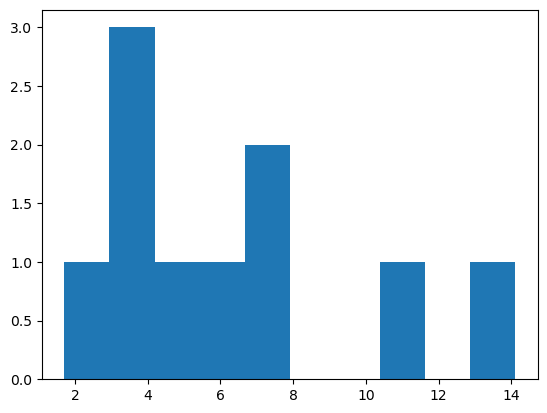

In [51]:
plt.hist(counts_groupby_cell_agg['Mean'])

Text(0, 0.5, 'Sum of MPRA UMI counts')

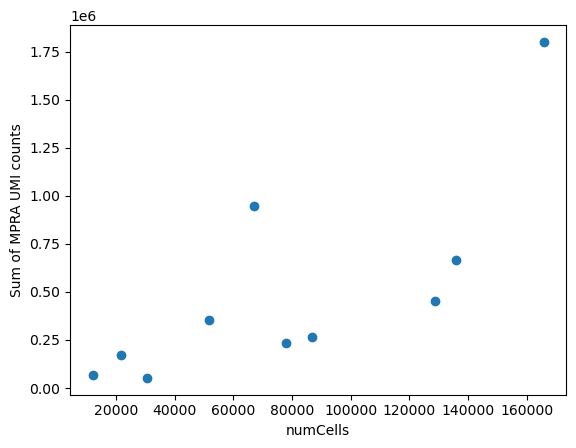

In [52]:
plt.scatter(counts_groupby_cell_agg['Size'], counts_groupby_cell_agg['Sum'])
plt.xlabel('numCells')
plt.ylabel('Sum of MPRA UMI counts')

Text(0, 0.5, 'Mean of MPRA UMI counts')

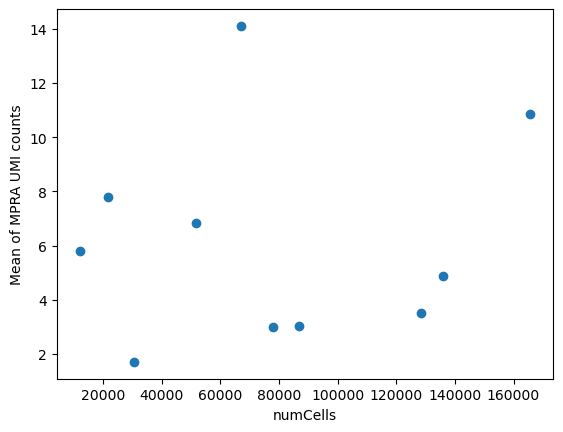

In [53]:
plt.scatter(counts_groupby_cell_agg['Size'], counts_groupby_cell_agg['Mean'])
plt.xlabel('numCells')
plt.ylabel('Mean of MPRA UMI counts')

In [63]:
cell_types = list(counts_groupby_cell_agg.index)
len(cell_types)

10

In [64]:
for i in cell_types:
    print(i)
    counts = counts_groupby_cre[counts_groupby_cre.cell_type_annotation == i]
    table = pa.Table.from_pandas(counts)
    pq.write_table(table, '../../../data/shendure_mpra_counts_%s.parq' % i)

Cardiomyocytes
EpiblastPrimitiveStreak
ExEndodermParietal
ExEndodermVisceral
Haematoendothelial
Mesoderm
NeuroectodermBrain
NeuroectodermRostral
Pluripotent
SurfaceEctoderm


In [65]:
count = 1
for i in cell_types:
    print(str(count) + '\t' + 'zi_negative_binomial'  + '\t' +  'UMIs_mBC~C(CRE_id)+0' + '\t' + 'rep_id' + '\t' + str(500000) + '\t' + i)
    count += 1

1	zi_negative_binomial	UMIs_mBC~C(CRE_id)+0	rep_id	500000	Cardiomyocytes
2	zi_negative_binomial	UMIs_mBC~C(CRE_id)+0	rep_id	500000	EpiblastPrimitiveStreak
3	zi_negative_binomial	UMIs_mBC~C(CRE_id)+0	rep_id	500000	ExEndodermParietal
4	zi_negative_binomial	UMIs_mBC~C(CRE_id)+0	rep_id	500000	ExEndodermVisceral
5	zi_negative_binomial	UMIs_mBC~C(CRE_id)+0	rep_id	500000	Haematoendothelial
6	zi_negative_binomial	UMIs_mBC~C(CRE_id)+0	rep_id	500000	Mesoderm
7	zi_negative_binomial	UMIs_mBC~C(CRE_id)+0	rep_id	500000	NeuroectodermBrain
8	zi_negative_binomial	UMIs_mBC~C(CRE_id)+0	rep_id	500000	NeuroectodermRostral
9	zi_negative_binomial	UMIs_mBC~C(CRE_id)+0	rep_id	500000	Pluripotent
10	zi_negative_binomial	UMIs_mBC~C(CRE_id)+0	rep_id	500000	SurfaceEctoderm


# separate CRE x  models w/ cell type as regressor (testing)

In [10]:

counts_groupby_cre_agg = counts_groupby_cre.groupby(['CRE_id']).agg(
    Sum=('UMIs_mBC', 'sum'), Size=('UMIs_mBC','size'), Mean=('UMIs_mBC', 'mean')
)

In [20]:
plt.hist(counts_groupby_cre_agg['Mean'], bins = 50)

NameError: name 'counts_groupby_cre_agg' is not defined

Text(0, 0.5, 'Sum of MPRA UMI counts')

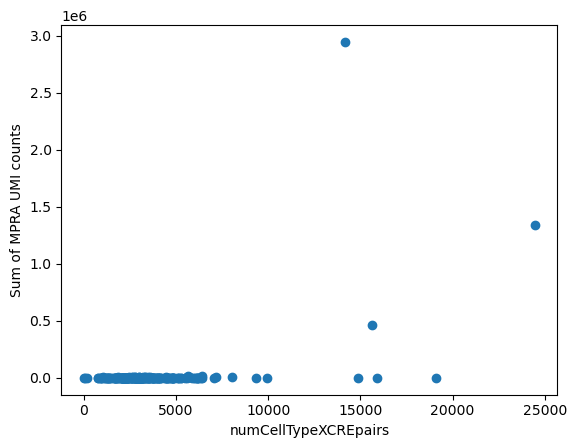

In [12]:
plt.scatter(counts_groupby_cre_agg['Size'], counts_groupby_cre_agg['Sum'])
plt.xlabel('numCellTypeXCREpairs')
plt.ylabel('Sum of MPRA UMI counts')

Text(0, 0.5, 'Mean of MPRA UMI counts')

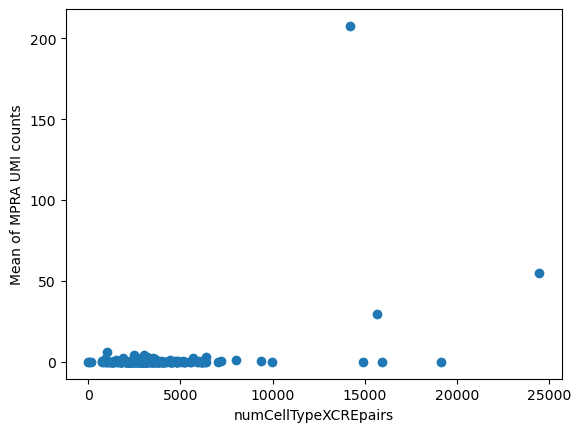

In [13]:
plt.scatter(counts_groupby_cre_agg['Size'], counts_groupby_cre_agg['Mean'])
plt.xlabel('numCellTypeXCREpairs')
plt.ylabel('Mean of MPRA UMI counts')

In [14]:
cres = list(counts_groupby_cre_agg.index)
len(cres)

212

In [15]:
# for i in celltype_creid_pairs:
#     print(i)
#     counts = counts_groupby_cre[counts_groupby_cre.CRE_id == i]
#     table = pa.Table.from_pandas(counts)
#     pq.write_table(table, '../../../data/shendure_mpra_counts_%s.parq' % i)

In [16]:
# count = 1
# for i in cres:
#     print(str(count) + '\t' + 'zi_negative_binomial'  + '\t' +  'UMIs_mBC~C(cell_type_annotation)+0' + '\t' + 'rep_id' + '\t' + str(50000) + '\t' + i)
#     count += 1


In [17]:
tests = pd.read_table('/vast/palmer/scratch/reilly/eng26/scmpra_temp/CRE_grouped_summary_stats.txt')

tests['CRE'] = cres
tests

,idx,model_choice,formula,maxiter,zi_param,converged,aic,bic,loglike,llr_chi2,llr_chi2_pval,psuedor2,resids,CRE
0,1,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,545.933,647.697,-255.966,31.308,0.000,0.058,NaN,Bend5_chr4_8168
1,2,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,511.351,608.155,-238.675,66.930,0.000,0.123,NaN,Bend5_chr4_8170
2,3,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,335.640,432.124,-150.820,7.795,0.555,0.025,NaN,Bend5_chr4_8172
3,4,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,False,2479.147,2592.707,-1222.573,497.013,0.000,0.169,NaN,Bend5_chr4_8174
4,5,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,11168.910,11277.671,-5567.455,89.430,0.000,0.008,NaN,Bend5_chr4_8175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,208,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,6122.812,6253.273,-3044.406,593.646,0.000,0.089,NaN,minP
208,209,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,minP_w_20bp_buffer
209,210,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,False,8278.148,8411.737,-4122.074,645.127,0.000,0.073,NaN,noP
210,211,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,224730.655,224868.435,-112348.327,5043.395,0.000,0.022,NaN,pgk1P


In [18]:
tests = tests.merge(counts_groupby_cre_agg, left_on = 'CRE', right_index=True)

In [19]:
tests[tests.converged==True]

,idx,model_choice,formula,maxiter,zi_param,converged,aic,bic,loglike,llr_chi2,llr_chi2_pval,psuedor2,resids,CRE,Sum,Size,Mean
0,1,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,545.933,647.697,-255.966,31.308,0.000,0.058,NaN,Bend5_chr4_8168,66,2940,0.022
1,2,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,511.351,608.155,-238.675,66.930,0.000,0.123,NaN,Bend5_chr4_8170,118,2196,0.054
2,3,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,335.640,432.124,-150.820,7.795,0.555,0.025,NaN,Bend5_chr4_8172,36,2155,0.017
4,5,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,11168.910,11277.671,-5567.455,89.430,0.000,0.008,NaN,Bend5_chr4_8175,3959,4437,0.892
8,9,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,4015.791,4129.781,-1990.895,1299.869,0.000,0.246,NaN,Bend5_chr4_8201,1957,6035,0.324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,206,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,12524.904,12637.929,-6245.452,765.565,0.000,0.058,NaN,Txndc12_chr4_7978,8424,5702,1.477
206,207,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,158031.110,158159.636,-78998.555,1993.299,0.000,0.012,NaN,eef1aP,2946499,14191,207.632
207,208,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,6122.812,6253.273,-3044.406,593.646,0.000,0.089,NaN,minP,1167,15902,0.073
210,211,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,224730.655,224868.435,-112348.327,5043.395,0.000,0.022,NaN,pgk1P,1342406,24459,54.884


In [20]:
tests.converged

0       True
1       True
2       True
3      False
4       True
       ...  
207     True
208    False
209    False
210     True
211     True
Name: converged, Length: 212, dtype: object

Text(0.5, 1.0, 'TtestResult(statistic=np.float64(0.08419647102944877), pvalue=np.float64(0.9329831740240894), df=np.float64(203.0557394092564))')

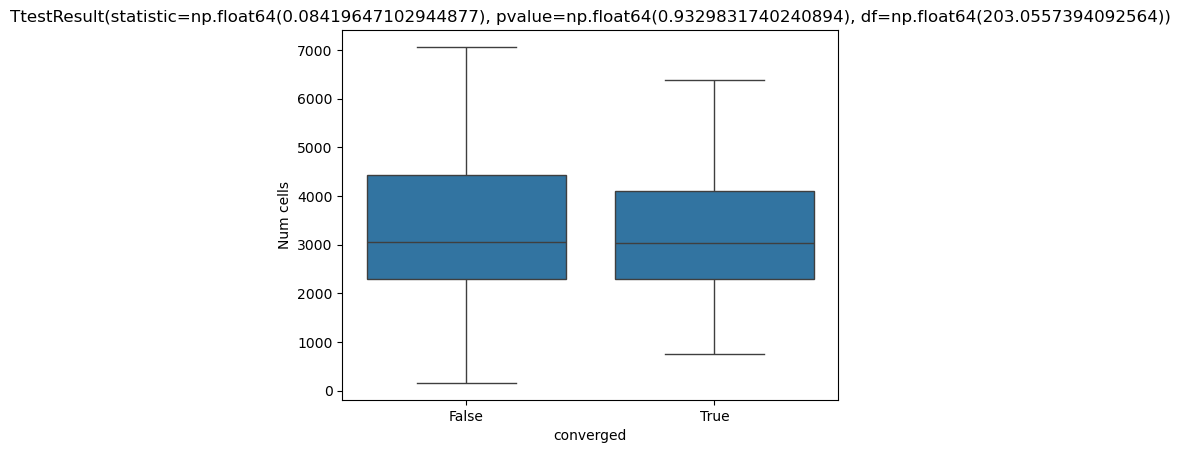

In [21]:
sns.boxplot(data = tests, x = 'converged', y = 'Size', showfliers = False)
plt.ylabel('Num cells')
plt.title(ttest_ind(tests[tests.converged==True]['Size'], tests[tests.converged==False]['Size'], nan_policy='omit', equal_var=False))

Text(0.5, 1.0, 'TtestResult(statistic=np.float64(1.5229237381713836), pvalue=np.float64(0.1303870257054118), df=np.float64(121.00045434493892))')

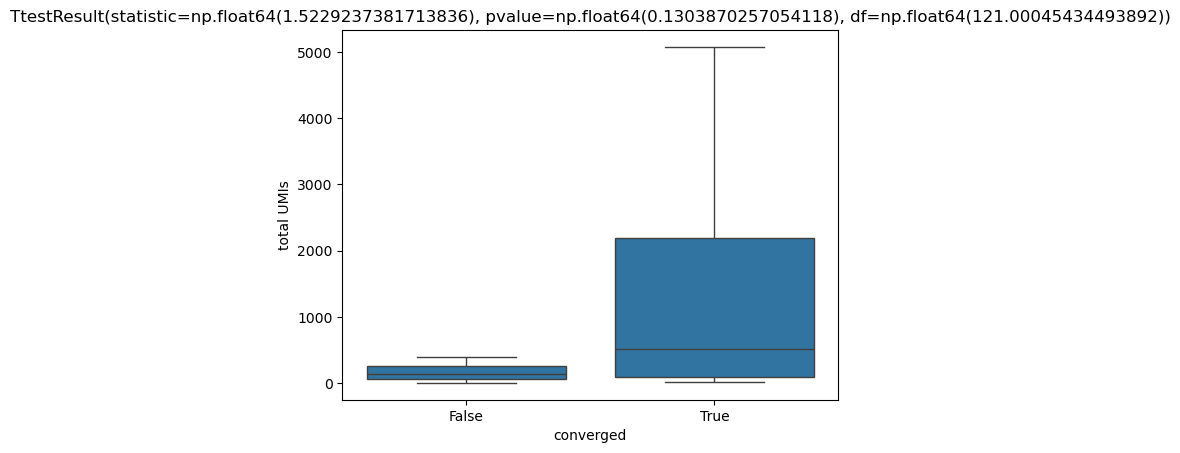

In [22]:
sns.boxplot(data = tests, x = 'converged', y = 'Sum', showfliers = False)
plt.ylabel('total UMIs')
plt.title(ttest_ind(tests[tests.converged==True]['Sum'], tests[tests.converged==False]['Sum'], equal_var=False))

Text(0.5, 1.0, 'TtestResult(statistic=np.float64(1.6397798560163113), pvalue=np.float64(0.10364820002682518), df=np.float64(121.00337624495289))')

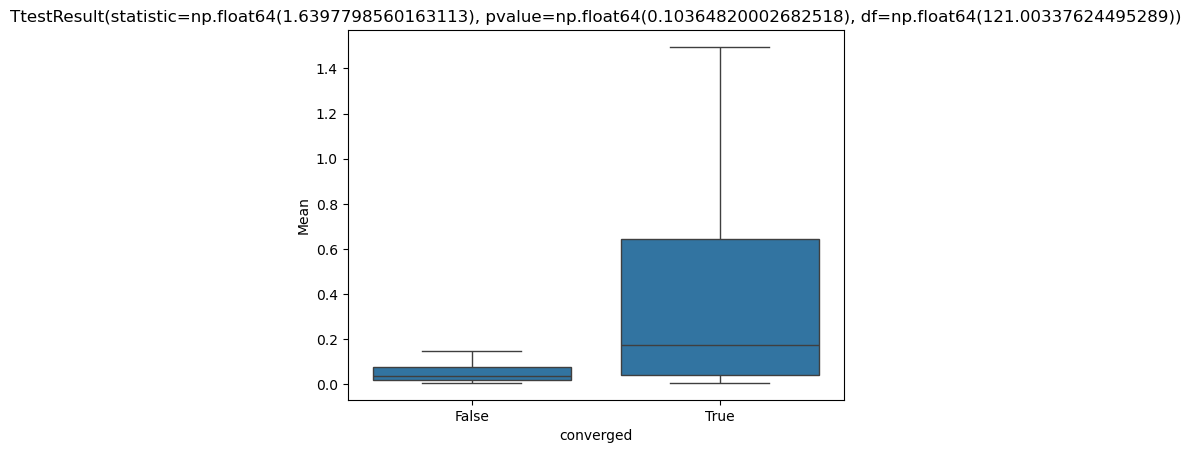

In [23]:
sns.boxplot(data = tests, x = 'converged', y = 'Mean', showfliers=False)
plt.title(ttest_ind(tests[tests.converged==True]['Mean'], tests[tests.converged==False]['Mean'], equal_var=False))

In [24]:
tests

,idx,model_choice,formula,maxiter,zi_param,converged,aic,bic,loglike,llr_chi2,llr_chi2_pval,psuedor2,resids,CRE,Sum,Size,Mean
0,1,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,545.933,647.697,-255.966,31.308,0.000,0.058,NaN,Bend5_chr4_8168,66,2940,0.022
1,2,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,511.351,608.155,-238.675,66.930,0.000,0.123,NaN,Bend5_chr4_8170,118,2196,0.054
2,3,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,335.640,432.124,-150.820,7.795,0.555,0.025,NaN,Bend5_chr4_8172,36,2155,0.017
3,4,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,False,2479.147,2592.707,-1222.573,497.013,0.000,0.169,NaN,Bend5_chr4_8174,705,5884,0.120
4,5,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,11168.910,11277.671,-5567.455,89.430,0.000,0.008,NaN,Bend5_chr4_8175,3959,4437,0.892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,208,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,6122.812,6253.273,-3044.406,593.646,0.000,0.089,NaN,minP,1167,15902,0.073
208,209,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,minP_w_20bp_buffer,2,161,0.012
209,210,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,False,8278.148,8411.737,-4122.074,645.127,0.000,0.073,NaN,noP,1821,19115,0.095
210,211,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,224730.655,224868.435,-112348.327,5043.395,0.000,0.022,NaN,pgk1P,1342406,24459,54.884


In [83]:
model_dict = {}
dir = '/vast/palmer/scratch/reilly/eng26/scmpra_temp/CRE_indi_models/'
files = os.listdir(dir)
for file in files:
    cre_name = '_'.join(file.split('_')[1:4])
    if (cre_name.split('_')[1] == 'GROUPED'):
        print(cre_name)
        cre_name = cre_name.split('_')[0]
    elif (cre_name.split('_')[1] == 'w'):
        cre_name = '_'.join(file.split('_')[1:5])
    if file.split('_')[-1] == 'model.pickle':
        model = pickle.load(open("%s/%s" % (dir, file), "rb"))
        model_dict[cre_name] = model   


eef1aP_GROUPED_zi
eef1aP_GROUPED_zi
minP_GROUPED_zi
minP_GROUPED_zi
noP_GROUPED_zi
noP_GROUPED_zi
pgk1P_GROUPED_zi
pgk1P_GROUPED_zi
ubcP_GROUPED_zi
ubcP_GROUPED_zi


In [119]:
alphas = []
alpha_se = []
for c in cres:
    alphas.append(model_dict[c].params['alpha'])
    alpha_se.append(model_dict[c].bse['alpha'])
tests['alpha'] = alphas
tests['alpha_se'] = alpha_se

In [88]:
tests

,idx,model_choice,formula,maxiter,zi_param,converged,aic,bic,loglike,llr_chi2,llr_chi2_pval,psuedor2,resids,CRE,Sum,Size,Mean,alpha
0,1,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,545.933,647.697,-255.966,31.308,0.000,0.058,NaN,Bend5_chr4_8168,66,2940,0.022,21.888
1,2,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,511.351,608.155,-238.675,66.930,0.000,0.123,NaN,Bend5_chr4_8170,118,2196,0.054,5.590
2,3,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,335.640,432.124,-150.820,7.795,0.555,0.025,NaN,Bend5_chr4_8172,36,2155,0.017,2.496
3,4,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,False,2479.147,2592.707,-1222.573,497.013,0.000,0.169,NaN,Bend5_chr4_8174,705,5884,0.120,6.076
4,5,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,11168.910,11277.671,-5567.455,89.430,0.000,0.008,NaN,Bend5_chr4_8175,3959,4437,0.892,2.116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,208,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,6122.812,6253.273,-3044.406,593.646,0.000,0.089,NaN,minP,1167,15902,0.073,12.510
208,209,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,minP_w_20bp_buffer,2,161,0.012,-813.495
209,210,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,False,8278.148,8411.737,-4122.074,645.127,0.000,0.073,NaN,noP,1821,19115,0.095,15.479
210,211,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,224730.655,224868.435,-112348.327,5043.395,0.000,0.022,NaN,pgk1P,1342406,24459,54.884,2.083


<Axes: xlabel='converged', ylabel='alpha'>

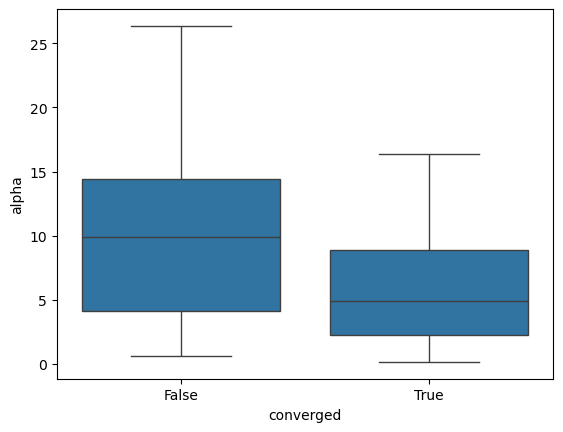

In [98]:
sns.boxplot(data = tests, x = 'converged', y = 'alpha', showfliers=False)

Text(0.5, 0, 'alpha')

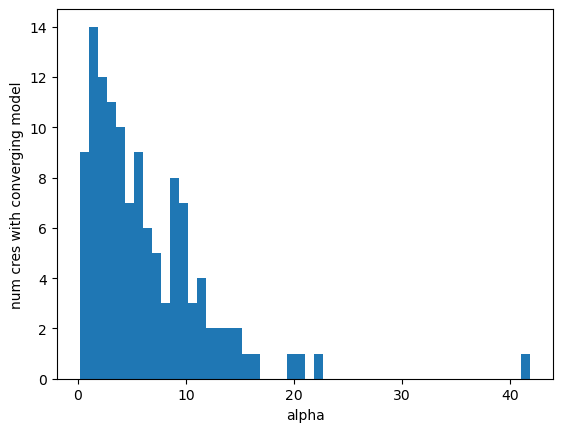

In [102]:
plt.hist(tests[tests.converged==True]['alpha'], bins = 50)
plt.ylabel('num cres with converging model')
plt.xlabel('alpha')

Text(0.5, 0, 'alpha_se')

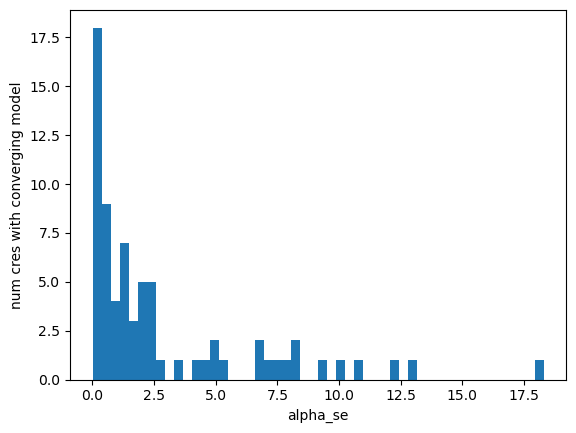

In [120]:
plt.hist(tests[tests.converged==True]['alpha_se'], bins = 50)
plt.ylabel('num cres with converging model')
plt.xlabel('alpha_se')

Text(0, 0.5, 'alpha_se')

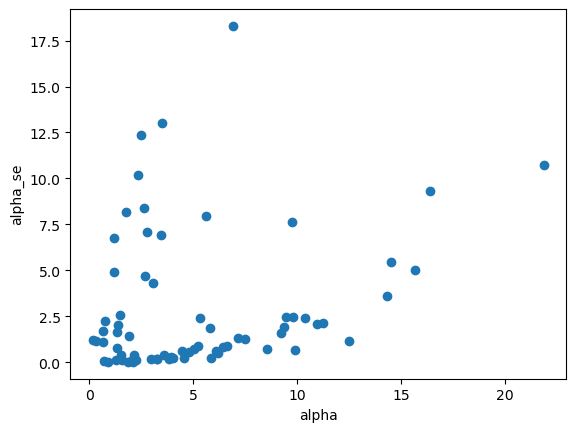

In [122]:
plt.scatter(tests[tests.converged==True]['alpha'], tests[tests.converged==True]['alpha_se'])
plt.xlabel('alpha')
plt.ylabel('alpha_se')

In [111]:
model_dict[c].__dict__.keys()

dict_keys(['_results', '__doc__'])

In [112]:
m = model_dict[c]

In [116]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                          UMIs_mBC   No. Observations:                15634
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    15624
Method:                                      MLE   Df Model:                            9
Date:                           Thu, 27 Feb 2025   Pseudo R-squ.:                 0.02978
Time:                                   12:41:35   Log-Likelihood:                -66099.
converged:                                  True   LL-Null:                       -68128.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
inflate_2B1                                           -2.8071      0.108    -25.994      0.000      -3.019      -2.595
inflate_2B2                                           -2.9174      0.101    -28.790      0.000      -3.116      -2.719
inflate_A1                                            -2.1664      0.090    -24.117      0.000      -2.342      -1.990
inflate_A2                                            -2.1973      0.084    -26.036      0.000      -2.363      -2.032
inflate_B1                                            -3.1032      0.130    -23.949      0.000      -3.357      -2.849
inflate_B2                                            -3.1339      0.132    -23.777      0.000      -3.392      -2.876
C(cell_type_annotation)[Cardiomyocytes]                3.2712      0.070     46.737      0.000       3.134       3.408
C(cell_type_annotation)[Epiblast/primitive streak]     4.0123      0.028    141.597      0.000       3.957       4.068
C(cell_type_annotation)[Ex. Endoderm (parietal)]       3.5999      0.023    154.939      0.000       3.554       3.645
C(cell_type_annotation)[Ex. Endoderm (visceral)]       3.5304      0.030    118.169      0.000       3.472       3.589
C(cell_type_annotation)[Haematoendothelial]            3.4975      0.052     67.900      0.000       3.397       3.598
C(cell_type_annotation)[Mesoderm]                      2.7854      0.021    135.393      0.000       2.745       2.826
C(cell_type_annotation)[Neuroectoderm (brain)]         2.6891      0.020    133.308      0.000       2.650       2.729
C(cell_type_annotation)[Neuroectoderm (rostral)]       2.6288      0.042     62.764      0.000       2.547       2.711
C(cell_type_annotation)[Pluripotent]                   4.0450      0.018    224.229      0.000       4.010       4.080
C(cell_type_annotation)[Surface Ectoderm]              2.9827      0.025    120.138      0.000       2.934       3.031
alpha                                                  0.9155      0.013     69.065      0.000       0.889       0.941
======================================================================================================================
"""

In [117]:
m.bse

inflate_2B1                                          0.108
inflate_2B2                                          0.101
inflate_A1                                           0.090
inflate_A2                                           0.084
inflate_B1                                           0.130
inflate_B2                                           0.132
C(cell_type_annotation)[Cardiomyocytes]              0.070
C(cell_type_annotation)[Epiblast/primitive streak]   0.028
C(cell_type_annotation)[Ex. Endoderm (parietal)]     0.023
C(cell_type_annotation)[Ex. Endoderm (visceral)]     0.030
C(cell_type_annotation)[Haematoendothelial]          0.052
C(cell_type_annotation)[Mesoderm]                    0.021
C(cell_type_annotation)[Neuroectoderm (brain)]       0.020
C(cell_type_annotation)[Neuroectoderm (rostral)]     0.042
C(cell_type_annotation)[Pluripotent]                 0.018
C(cell_type_annotation)[Surface Ectoderm]            0.025
alpha                                                0.0

In [123]:
tests

,idx,model_choice,formula,maxiter,zi_param,converged,aic,bic,loglike,llr_chi2,llr_chi2_pval,psuedor2,resids,CRE,Sum,Size,Mean,alpha,alpha_se
0,1,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,545.933,647.697,-255.966,31.308,0.000,0.058,NaN,Bend5_chr4_8168,66,2940,0.022,21.888,10.743
1,2,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,511.351,608.155,-238.675,66.930,0.000,0.123,NaN,Bend5_chr4_8170,118,2196,0.054,5.590,7.966
2,3,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,335.640,432.124,-150.820,7.795,0.555,0.025,NaN,Bend5_chr4_8172,36,2155,0.017,2.496,12.382
3,4,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,False,2479.147,2592.707,-1222.573,497.013,0.000,0.169,NaN,Bend5_chr4_8174,705,5884,0.120,6.076,0.866
4,5,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,11168.910,11277.671,-5567.455,89.430,0.000,0.008,NaN,Bend5_chr4_8175,3959,4437,0.892,2.116,0.124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,208,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,6122.812,6253.273,-3044.406,593.646,0.000,0.089,NaN,minP,1167,15902,0.073,12.510,1.135
208,209,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,minP_w_20bp_buffer,2,161,0.012,-813.495,NaN
209,210,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,False,8278.148,8411.737,-4122.074,645.127,0.000,0.073,NaN,noP,1821,19115,0.095,15.479,1.245
210,211,zi_negative_binomial,UMIs_mBC~C(cell_type_annotation)+0,50000,rep_id,True,224730.655,224868.435,-112348.327,5043.395,0.000,0.022,NaN,pgk1P,1342406,24459,54.884,2.083,0.017


# CRE x Cell Type models

In [ ]:
counts_groupby_cre_celltype_agg = counts_groupby_cre.groupby(['cell_type_annotation','CRE_id']).agg(
    Sum=('UMIs_mBC', 'sum'), Size=('UMIs_mBC','size'), Mean=('UMIs_mBC', 'mean')
)

Text(0.5, 1.0, 'CellBCs by CelltypeXCRE pair')

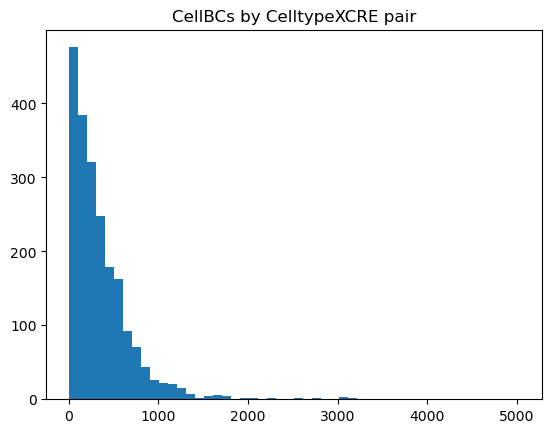

In [ ]:
plt.hist(counts_groupby_cre_celltype_agg['Size'], bins = 50)
plt.title('CellBCs by CelltypeXCRE pair')

In [ ]:
counts_groupby_cre_celltype_agg['Sum'].describe()

count      2113.000
mean       2369.381
std       32433.864
min           0.000
25%           2.000
50%           9.000
75%          50.000
max     1083707.000
Name: Sum, dtype: float64

Text(0.5, 1.0, 'Total UMIs by CelltypeXCRE pair (filtered to UMIs > 100)')

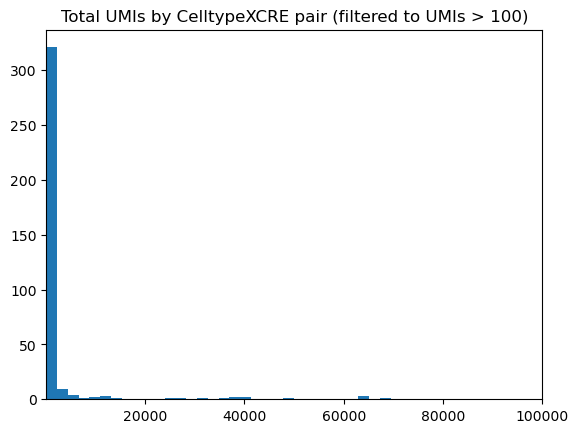

In [ ]:
plt.hist(counts_groupby_cre_celltype_agg[counts_groupby_cre_celltype_agg['Sum']>100]['Sum'], bins = 500)
plt.xlim(100,100000)
plt.title('Total UMIs by CelltypeXCRE pair (filtered to UMIs > 100)')

In [ ]:
counts_df = counts_groupby_cre[counts_groupby_cre.cell_type_annotation == celltype_creid_pairs[0][0]][counts_groupby_cre.CRE_id == celltype_creid_pairs[0][1]]